In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from utils import *
from utils_plotting import *
from utils_evaluation import *

In [3]:
sns.set(style='ticks')
sns.set_palette('cubehelix')

# Prepare data

In [4]:
kids_x_sdss = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv', sdss_cleaning=True, cut='r')

Data shape: (91317, 49)
Droping NANs: 89513 (98.02%) left
Removing errors bigger than 1: 84491 (92.52%) left
Removing limiting magnitudes: 74191 (81.25%) left
Removing IMA flags: 55787 (61.09%) left
Cleaning SDSS: 52010 left
Removing R > 22: 51752 left


In [5]:
catalog = pd.read_csv('outputs/catalogs/KiDS_DR3_x_SDSS_DR14_sdss-clean_rf-clf_f-all_cut-r__2018-08-27_14:37:20.csv')
print(catalog.shape)

(3392580, 18)


In [6]:
kids_x_gaia = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.DR2.cols.csv', sdss_cleaning=False, cut='r')

Data shape: (1965257, 54)
Droping NANs: 1937863 (98.61%) left
Removing errors bigger than 1: 1855478 (94.41%) left
Removing limiting magnitudes: 1619387 (82.40%) left
Removing IMA flags: 1080301 (54.97%) left
Removing R > 22: 1080253 left


In [7]:
catalog['train'] = catalog['ID'].isin(kids_x_sdss['ID'])
print(catalog.shape)

(3392580, 19)


In [8]:
catalog_x_gaia = pd.merge(catalog, kids_x_gaia, on='ID', suffixes=('', '_right'))

In [9]:
qso_kids_sdss = kids_x_sdss.loc[kids_x_sdss['CLASS'] == 'QSO']
qso_catalog = catalog.loc[catalog['CLASS'] == 'QSO']

In [10]:
catalog_sampled = catalog.sample(n=500000, random_state=1567)
qso_catalog_sampled = qso_catalog.sample(n=100000, random_state=1567)

In [11]:
catalog_north = catalog.loc[catalog['DECJ2000'] > -15]
catalog_south = catalog.loc[catalog['DECJ2000'] < -15]

In [12]:
catalog_star = catalog.loc[catalog['CLASS_STAR'] >= 0.5]
catalog_non_star = catalog.loc[catalog['CLASS_STAR'] <= 0.5]

In [13]:
qso_catalog_clean = qso_catalog.loc[qso_catalog['QSO'] >= 0.7]

# Describe data

In [14]:
print(qso_catalog.shape[0])

192527


In [15]:
describe_column(kids_x_sdss['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([32547,  7061, 12144]),
 array([ 62.89032308,  13.64391714,  23.46575978]))

In [16]:
describe_column(catalog['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([2012086,  192527, 1187967]),
 array([ 59.30843193,   5.67494355,  35.01662452]))

In [17]:
catalog_x_gaia.shape

(1080253, 82)

In [18]:
describe_column(catalog_x_gaia['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([  39761,   38168, 1002324]),
 array([  3.68071183,   3.53324638,  92.78604179]))

In [19]:
describe_column(catalog_north['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([1295333,  124268,  844468]),
 array([ 57.21261145,   5.48870198,  37.29868657]))

In [20]:
describe_column(catalog_south['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([716753,  68259, 343499]),
 array([ 63.51316026,   6.04858969,  30.43825005]))

In [21]:
describe_column(catalog_star['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([  15688,  172231, 1176616]),
 array([  1.14969568,  12.62195546,  86.22834885]))

In [22]:
describe_column(catalog_non_star['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([1996398,   20296,   11351]),
 array([ 98.43953167,   1.00076675,   0.55970158]))

In [23]:
qso_catalog_clean.shape

(107385, 19)

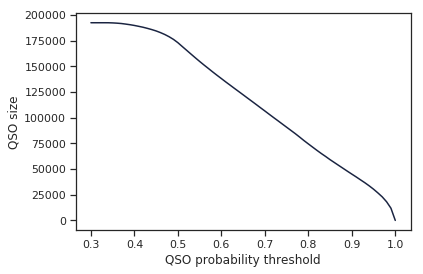

In [24]:
plot_proba_against_size(qso_catalog, column='QSO', x_lim=(0.3, 1))

# External catalogs

catalog size: 3392580
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([2012086,  192527, 1187967]), array([59.30843193,  5.67494355, 35.01662452]))
--------------------
KiDS.DR3.x.2QZ6QZ.cols
ext. catalog x base set size: 6131
ext. catalog x base catalog size: 5376, train elements: 1186
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  46, 5234,   96]), array([ 0.85565476, 97.35863095,  1.78571429]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  42, 4054,   94]), array([ 1.00238663, 96.75417661,  2.24343675]))
--------------------
KiDS.DR3.x.QSO.RICHARDS.2009
ext. catalog x base set size: 19930
ext. catalog x base catalog size: 16851, train elements: 3508
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  819, 14565,  1467]), array([ 4.86024568, 86.43403952,  8.70571479]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  791, 11177,  1375]), array([ 5.92820205,

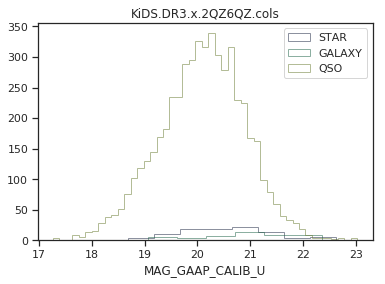

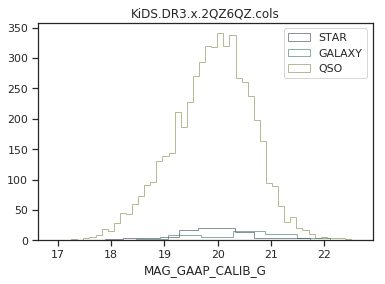

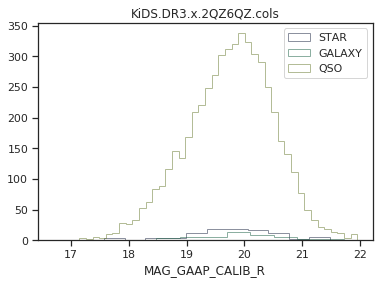

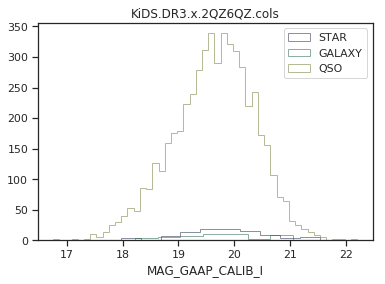

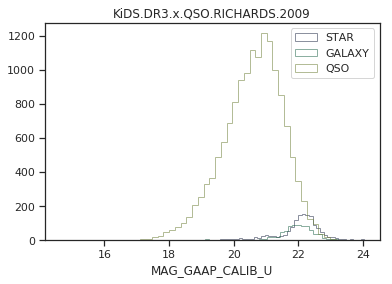

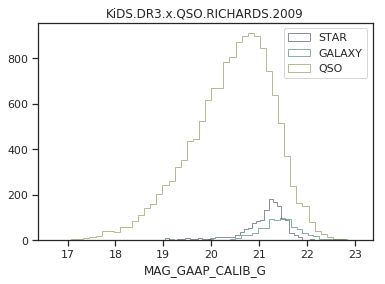

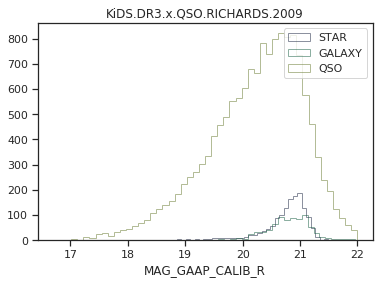

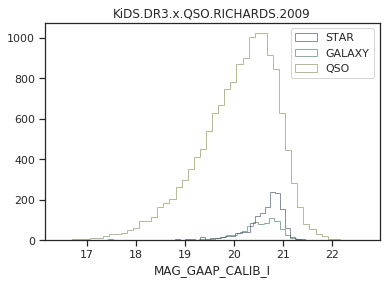

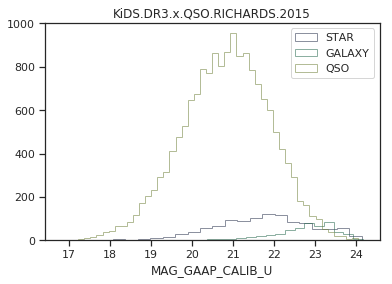

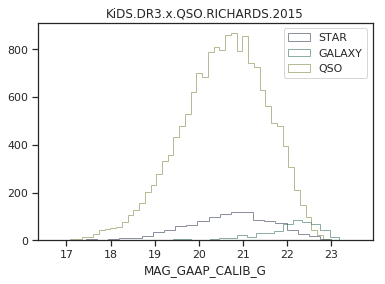

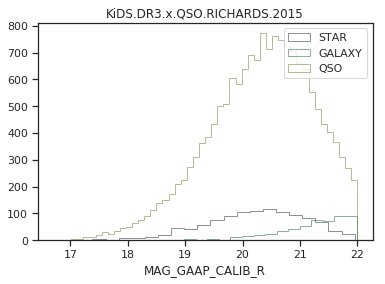

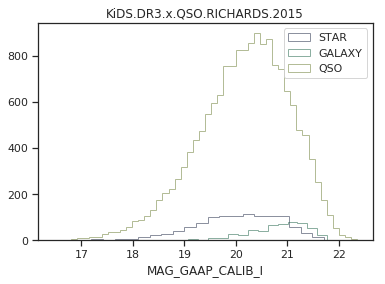

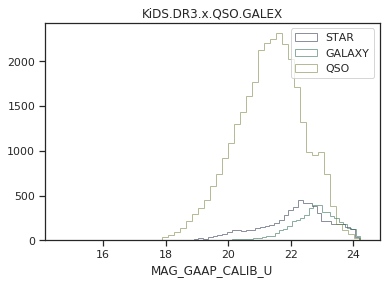

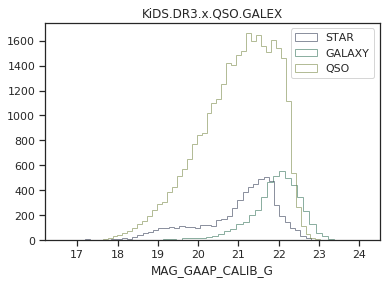

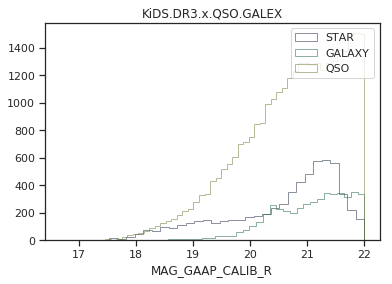

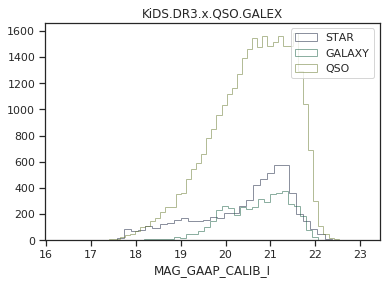

In [25]:
test_external_qso(catalog, save=False)

In [28]:
ext_catalog = pd.read_csv('/media/snakoneczny/data/KiDS/KiDS.DR3.x.2QZ6QZ.cols.csv')
ext_catalog = process_2df(ext_catalog)
ext_catalog = ext_catalog.loc[ext_catalog['id1'].isin(['GALAXY', 'QSO', 'STAR'])]
catalogs_cross = pd.merge(catalog, ext_catalog, on='ID', suffixes=('', '_right'))

Multiclass classification results:
Accuracy = 0.9446
F1 per class = [ 0.1649  0.9631  0.9174]
Logloss = 0.4194


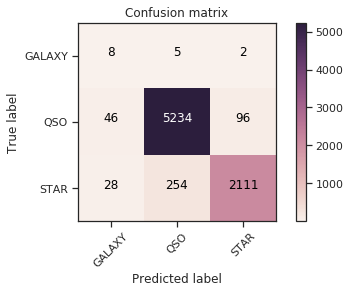

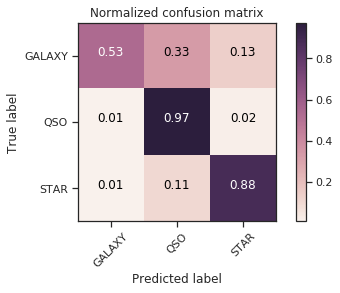

Binary classification results:
Predicted positives: 5493/7784 (70.57%)
logloss = 0.2889
ROC AUC = 0.9642


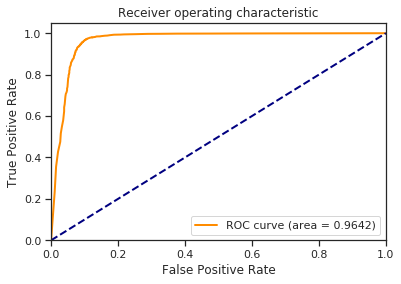

accuracy = 0.9485
f1 = 0.9631
precision = 0.9528
recall = 0.9736


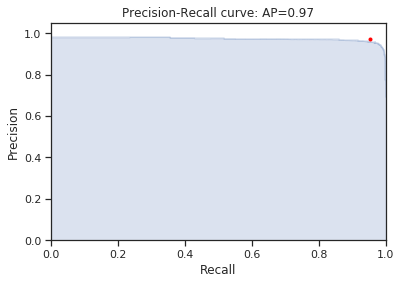

In [29]:
classification_report(catalogs_cross, col_true='id1')

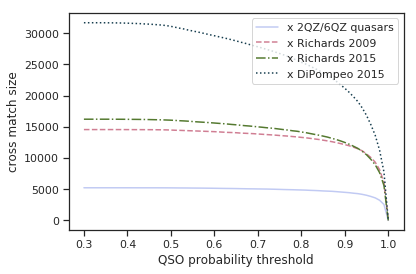

In [14]:
plot_proba_against_qxternal_qso(qso_catalog)

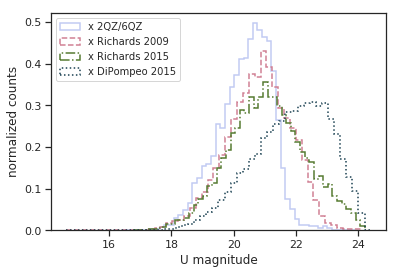

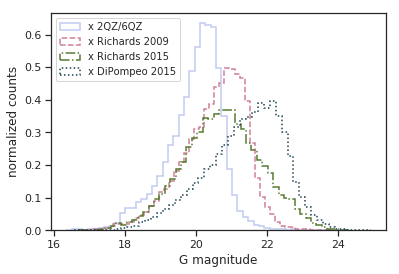

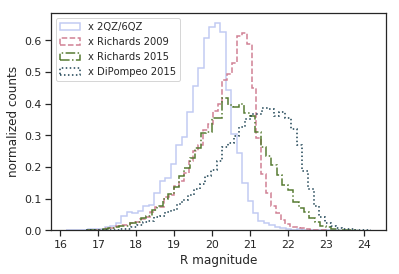

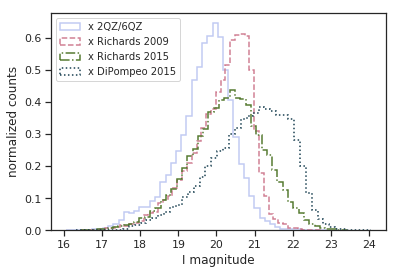

In [15]:
data_dict = OrderedDict((data_name, process_kids(data_path, with_print=False)) for data_name, data_path in EXTERNAL_QSO_DICT.items())
plot_histograms(data_dict, pretty_print_function=pretty_print_magnitude, legend_size=10)

# GAIA motion test

5 position shape: (919796, 82)


/home/snakoneczny/workspace/kids_quasars/utils.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[col + '_norm'] = data[col] / data[col + '_error']


Removing paralax_error shape: (805416, 85)
Removing pmra_error shape: (615601, 85)
Removing pmdec_error shape: (596231, 85)
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   515,   7097, 588619]), array([  8.63759181e-02,   1.19031047e+00,   9.87233136e+01]))
QSO:


,parallax,pmra,pmdec
mu,0.210346,-0.266008,-1.07721
median,0.00553898,-0.0151157,-0.0522698
sigma,1.42701,13.4044,9.91609


GALAXY:


,parallax,pmra,pmdec
mu,0.288999,-0.752666,-4.16943
median,0.212221,-0.380747,-2.01781
sigma,0.884438,7.93392,9.03638


STAR:


,parallax,pmra,pmdec
mu,0.793163,-2.65158,-5.83156
median,0.550957,-2.29961,-4.0721
sigma,1.04017,13.5241,11.0903


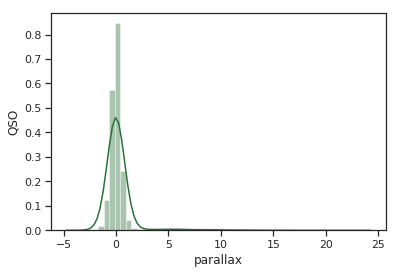

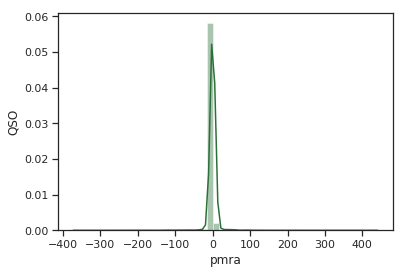

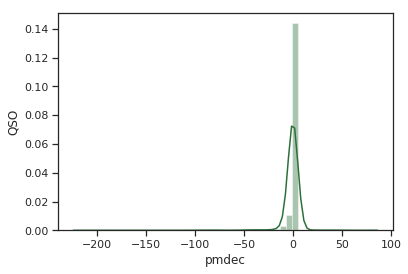

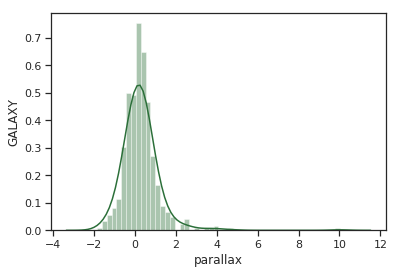

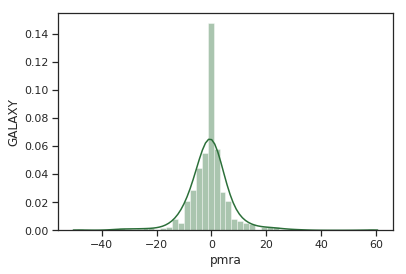

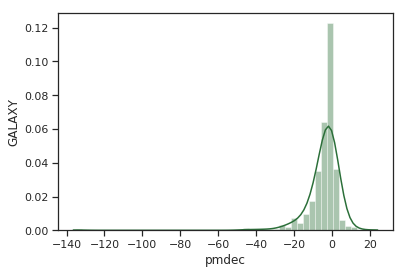

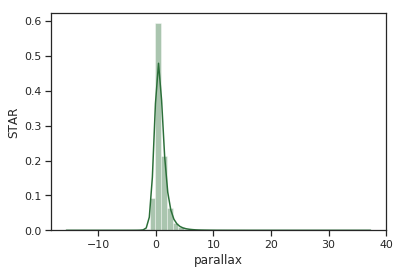

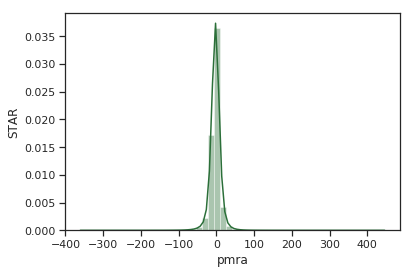

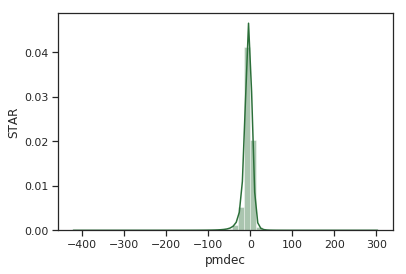

In [25]:
catalog_x_gaia_clean = process_gaia(catalog_x_gaia, parallax_error=1, pm_error=1)
print(describe_column(catalog_x_gaia_clean['CLASS']))
gaia_motion_analysis(catalog_x_gaia_clean)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:184: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:189: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


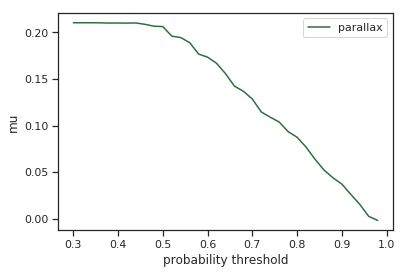

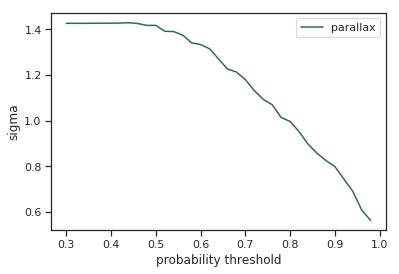

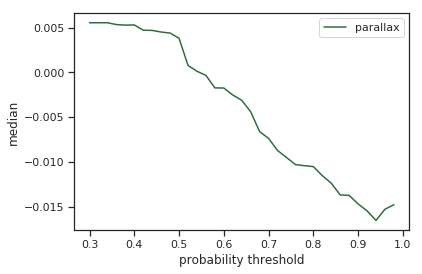

In [45]:
proba_motion_analysis(catalog_x_gaia_clean, motions=['parallax'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:184: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:189: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


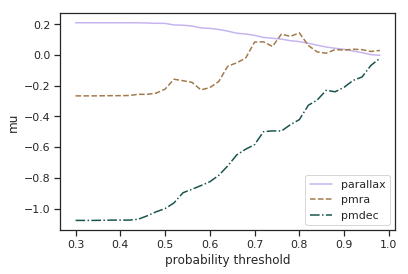

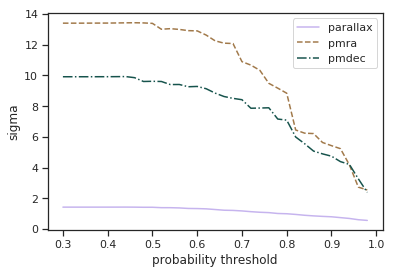

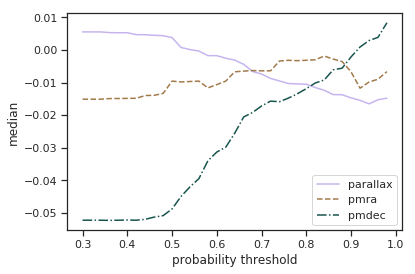

In [52]:
proba_motion_analysis(catalog_x_gaia_clean, motions=['parallax', 'pmra', 'pmdec'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:184: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:189: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


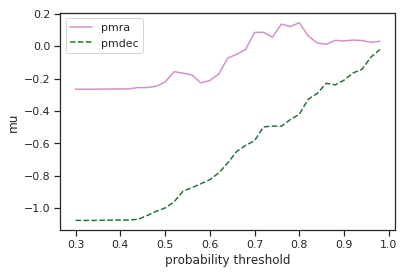

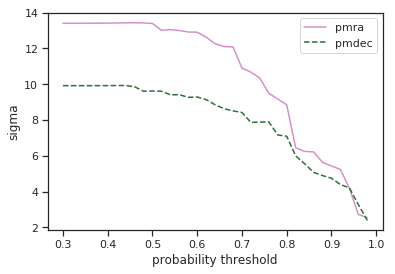

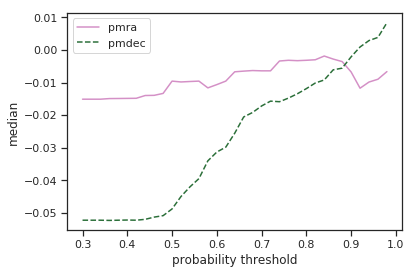

In [46]:
proba_motion_analysis(catalog_x_gaia_clean, motions=['pmra', 'pmdec'])

5 position shape: (892612, 82)


/home/snakoneczny/workspace/kids_quasars/utils.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[col + '_norm'] = data[col] / data[col + '_error']


Removing paralax_error shape: (788578, 85)
Removing pmra_error shape: (606702, 85)
Removing pmdec_error shape: (588444, 85)
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   199,   5794, 582451]), array([  3.38180014e-02,   9.84630653e-01,   9.89815513e+01]))
QSO:


,parallax,pmra,pmdec
mu,0.0874514,0.144734,-0.420679
median,-0.0105316,-0.00317039,-0.011874
sigma,0.996611,8.84383,7.09199


GALAXY:


,parallax,pmra,pmdec
mu,0.109324,-0.820409,-3.5547
median,0.12629,-0.078685,-0.933446
sigma,0.70605,6.77297,7.30839


STAR:


,parallax,pmra,pmdec
mu,0.796711,-2.66028,-5.83957
median,0.554445,-2.31838,-4.08318
sigma,1.03577,13.5109,11.0879


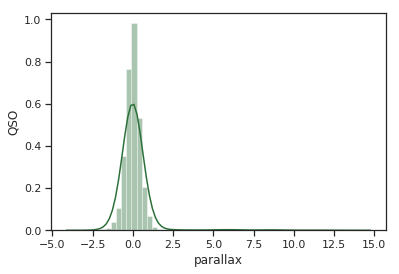

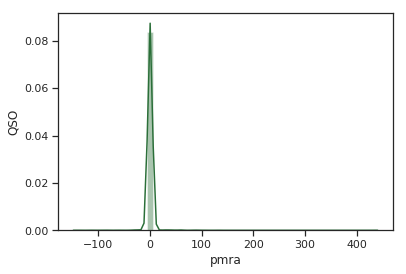

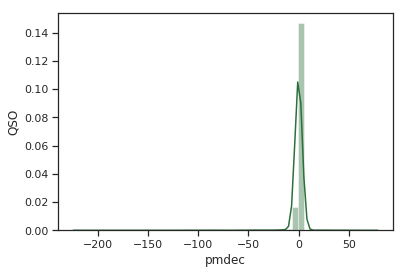

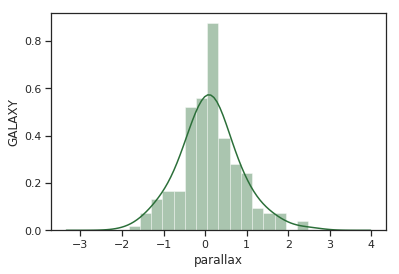

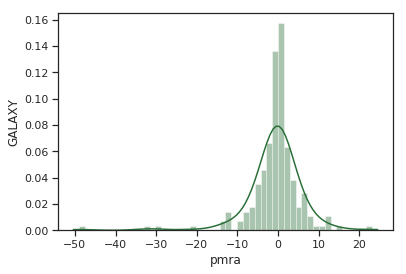

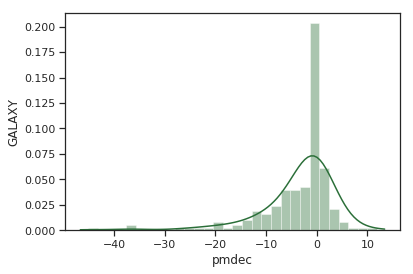

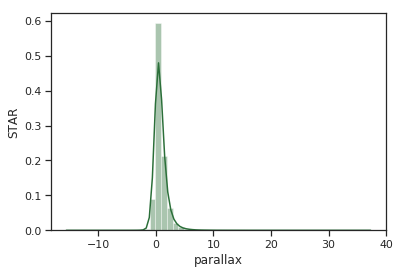

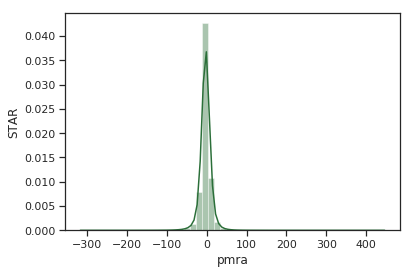

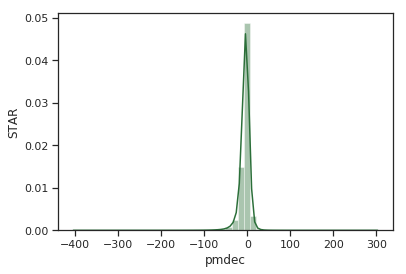

In [26]:
thr = 0.8
tmp = catalog_x_gaia.loc[(catalog_x_gaia['QSO'] > thr) | (catalog_x_gaia['GALAXY'] > thr) | (catalog_x_gaia['STAR'] > thr)]
tmp_clean = process_gaia(tmp, parallax_error=1, pm_error=1)
print(describe_column(tmp_clean['CLASS']))
gaia_motion_analysis(tmp_clean)

# t-SNE visualization

## Star

In [ ]:
catalog_to_plot = kids_x_sdss.loc[kids_x_sdss['CLASS_STAR'] >= 0.5].sample(10000, random_state=8945)
catalog_to_plot['CLASS'] += '_SDSS'
catalog_to_plot = catalog_to_plot.append(catalog_star.loc[~catalog_star['ID'].isin(kids_x_sdss['ID'])].sample(10000, random_state=1467))

In [ ]:
X = catalog_to_plot[FEATURES['magnitudes-colors-cstar']]
X_scaled = MinMaxScaler().fit_transform(X)

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
                  random_state=8934, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['CLASS'], label='class', alpha=0.4)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot[MAG_GAAP_CALIB_R], label='R magnitude', is_continuous=True)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['CLASS_STAR'], label='class star', is_continuous=True)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['DECJ2000'], label='declination', is_continuous=True)

## Non-star

In [ ]:
catalog_to_plot = kids_x_sdss.loc[kids_x_sdss['CLASS_STAR']<= 0.5].sample(10000, random_state=8945)
catalog_to_plot['CLASS'] += '_SDSS'
catalog_to_plot = catalog_to_plot.append(catalog_non_star.loc[~catalog_non_star['ID'].isin(kids_x_sdss['ID'])].sample(10000, random_state=1467))

In [ ]:
X = catalog_to_plot[FEATURES['magnitudes-colors-cstar']]
X_scaled = MinMaxScaler().fit_transform(X)

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
                  random_state=8934, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['CLASS'], label='class', alpha=0.4)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot[MAG_GAAP_CALIB_R], label='R magnitude', is_continuous=True)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['CLASS_STAR'], label='R magnitude', is_continuous=True)

# Standalone bands

In [ ]:
plot_class_histograms(kids_x_sdss, BAND_CALIB_COLUMNS)

In [ ]:
plot_class_histograms(catalog, BAND_CALIB_COLUMNS)

In [ ]:
plot_class_histograms(catalog_north, BAND_CALIB_COLUMNS)

In [ ]:
plot_class_histograms(catalog_south, BAND_CALIB_COLUMNS)

# Paired bands

In [ ]:
sns.pairplot(kids_x_sdss[np.concatenate([BAND_CALIB_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

In [ ]:
sns.pairplot(catalog_sampled[np.concatenate([BAND_CALIB_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

# Standalone colors

In [ ]:
plot_class_histograms(kids_x_sdss, COLOR_COLUMNS)

In [ ]:
plot_class_histograms(catalog, COLOR_COLUMNS)

# Paired colors

In [ ]:
sns.pairplot(kids_x_sdss[np.concatenate([COLOR_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

In [ ]:
sns.pairplot(catalog_sampled[np.concatenate([COLOR_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=kids_x_sdss, fit_reg=False, scatter_kws={'alpha': 0.25})

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=catalog_sampled, fit_reg=False, scatter_kws={'alpha': 0.25})

## CLASS_STAR

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=kids_x_sdss_non_star, fit_reg=False, scatter_kws={'alpha': 0.25})

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=catalog_non_star, fit_reg=False, scatter_kws={'alpha': 0.25})

# QSO color pairs

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.jointplot(qso_kids_sdss[b_1], qso_kids_sdss[b_2], kind='kde', stat_func=None)

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.jointplot(qso_catalog_sampled[b_1], qso_catalog_sampled[b_2], kind='kde', stat_func=None)

# Number counts analysis

/home/snakoneczny/workspace/kids_quasars/utils_evaluation.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['bin'] = pd.cut(data[band], bins, labels=False)


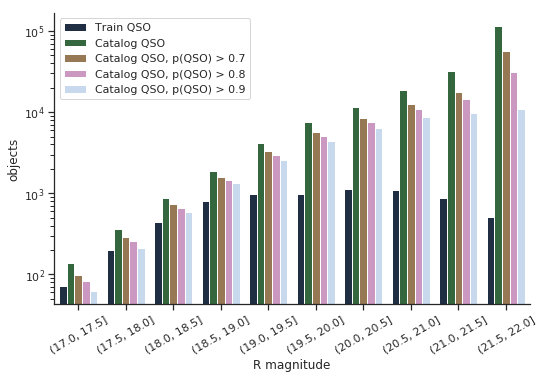

In [35]:
data_dict = {
    'Train QSO': qso_kids_sdss,
    'Catalog QSO': qso_catalog,
    'Catalog QSO, p(QSO) > 0.7': qso_catalog_clean,
    'Catalog QSO, p(QSO) > 0.8': qso_catalog.loc[qso_catalog['QSO'] > 0.8],
    'Catalog QSO, p(QSO) > 0.9': qso_catalog.loc[qso_catalog['QSO'] > 0.9],
}
number_counts_multidata(data_dict, x_lim=(17, 22), legend_loc='upper left')

/home/snakoneczny/workspace/kids_quasars/utils_evaluation.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['bin'] = pd.cut(data[band], bins, labels=False)


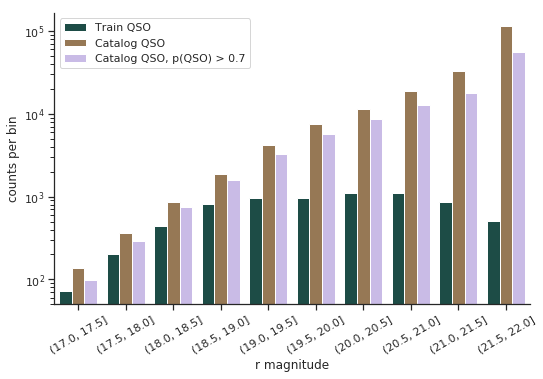

In [30]:
data_dict = {'Train QSO': qso_kids_sdss, 'Catalog QSO': qso_catalog, 'Catalog QSO, p(QSO) > 0.7': qso_catalog_clean}
number_counts_multidata(data_dict, x_lim=(17, 22), legend_loc='upper left')

/home/snakoneczny/workspace/kids_quasars/utils_evaluation.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['bin'] = pd.cut(data[band], bins, labels=False)


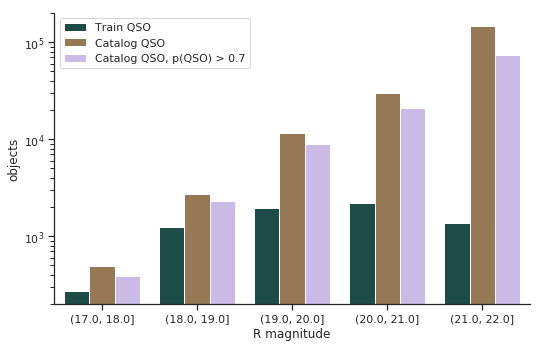

In [19]:
data_dict = {'Train QSO': qso_kids_sdss, 'Catalog QSO': qso_catalog, 'Catalog QSO, p(QSO) > 0.7': qso_catalog_clean}
number_counts_multidata(data_dict, x_lim=(17, 22), legend_loc='upper left')

## Create maps

In [ ]:
nside = 128

In [ ]:
# map_stars, lon, lat = get_weighted_map(nside=128)

In [ ]:
map_stars = np.loadtxt('/home/snakoneczny/workspace/kids_quasars/outputs/maps/GAIA_DR2_nside-{}_hpxmap.txt'.format(nside))

In [ ]:
map_kids_sdss, lon, lat = get_map(kids_x_sdss['GAL_LONG'], kids_x_sdss['GAL_LAT'], nside=nside)

In [ ]:
map_qso_kids_sdss, _, _ = get_map(qso_kids_sdss['GAL_LONG'], qso_kids_sdss['GAL_LAT'], nside=nside)

In [ ]:
map_catalog, _, _ = get_map(catalog['GAL_LONG'], catalog['GAL_LAT'], nside=nside)

In [ ]:
map_catalog_star, _, _ = get_map(catalog_star['GAL_LONG'], catalog_star['GAL_LAT'], nside=nside)

In [ ]:
map_qso_catalog, _, _ = get_map(qso_catalog['GAL_LONG'], qso_catalog['GAL_LAT'], nside=nside)

In [ ]:
map_qso_catalog_clean, _, _ = get_map(qso_catalog_clean['GAL_LONG'], qso_catalog_clean['GAL_LAT'], nside=nside)

In [ ]:
map_qso_normalized = normalize_map(map_qso_catalog, map_catalog)

In [ ]:
qso_catalog_parts = get_kids_parts(qso_catalog)
catalog_parts = get_kids_parts(catalog)

In [ ]:
map_qso_catalog_parts = [get_map(part['GAL_LONG'], part['GAL_LAT'], nside=nside)[0] for part in qso_catalog_parts]

In [ ]:
map_catalog_parts = [get_map(part['GAL_LONG'], part['GAL_LAT'], nside=nside)[0] for part in catalog_parts]

## Correlations

In [ ]:
# nside = 128
maps_x = [('catalog', map_catalog), ('QSO cat.', map_qso_catalog), ('QSO cat. norm.', map_qso_normalized),
          ('QSO cat. high', map_qso_catalog_high)]
maps_x.extend([('catalog part {}'.format(i + 1), m) for i, m in enumerate(map_catalog_parts)])
maps_x.extend([('qso part {}'.format(i + 1), m) for i, m in enumerate(map_qso_catalog_parts)])
maps_y = [('catalog', map_catalog), ('stars', map_stars), ('train', map_kids_sdss), ('train QSO', map_qso_kids_sdss)]

show_correlations(maps_x, maps_y)

In [ ]:
# nside = 1028
maps_x = [('catalog', map_catalog), ('QSO cat.', map_qso_catalog), ('QSO cat. norm.', map_qso_normalized),
          ('QSO cat. high', map_qso_catalog_high)]
maps_x.extend([('catalog part {}'.format(i + 1), m) for i, m in enumerate(map_catalog_parts)])
maps_x.extend([('qso part {}'.format(i + 1), m) for i, m in enumerate(map_qso_catalog_parts)])
maps_y = [('catalog', map_catalog), ('stars', map_stars), ('train', map_kids_sdss), ('train QSO', map_qso_kids_sdss)]

show_correlations(maps_x, maps_y)

In [ ]:
maps_x = [('catalog star', map_catalog), ('QSO', map_qso_catalog), ('QSO norm.', map_qso_normalized)]
maps_x.extend([('catalog part {}'.format(i + 1), m) for i, m in enumerate(map_catalog_parts)])
maps_x.extend([('qso part {}'.format(i + 1), m) for i, m in enumerate(map_qso_catalog_parts)])
maps_y = [('catalog star', map_catalog), ('stars', map_stars), ('train', map_kids_sdss), ('train QSO', map_qso_kids_sdss)]

show_correlations(maps_x, maps_y)

In [ ]:
%matplotlib inline
plot_map_stats(map_qso_catalog_parts[3], lat, map_stars, 'catalog QSO')

## Map visualization

In [ ]:
%matplotlib notebook
plot_map(map_stars, unit='average value per pixel', is_cmap=False)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_stars, lat)

In [ ]:
%matplotlib notebook
plot_map(map_kids_sdss)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_kids_sdss, lat, map_stars, 'KiDS x SDSS')

In [ ]:
%matplotlib notebook
plot_map(map_qso_kids_sdss)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_kids_sdss, lat, map_stars, 'KiDS x SDSS QSO')

In [ ]:
%matplotlib notebook
plot_map(map_catalog)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_catalog, lat, map_stars, 'catalog')

In [ ]:
%matplotlib notebook
plot_map(map_qso_catalog)

In [ ]:
%matplotlib notebook
plot_map(map_qso_catalog_clean)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_catalog, lat, map_stars, 'catalog QSO')

In [ ]:
%matplotlib notebook
plot_map(map_qso_catalog_high)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_catalog_high, lat, map_stars, 'catalog QSO')

In [ ]:
%matplotlib notebook
plot_map(map_qso_normalized, unit='normalized counts per pixel')

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_normalized, lat, map_stars, 'catalog QSO normalized')

# Predictions

In [ ]:
for t in [0, 1]:
    sns.distplot(catalog_star.loc[(catalog_star['train'] == t) & (catalog_star['CLASS'] == 'QSO')]['QSO'], label=str(t), kde=False, rug=False, hist_kws={'alpha': 0.5})
plt.legend()

In [ ]:
for t in [0, 1]:
    sns.distplot(catalog_non_star.loc[(catalog_non_star['train'] == t) & (catalog_non_star['CLASS'] == 'QSO')]['QSO'], label=str(t), kde=False, rug=False, hist_kws={'alpha': 0.5})
plt.legend()